In [71]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from deploy import load_segmentation, load_classifier, run_model, denorm_img, load_bin_classifiers
from segmenter import g_fns, show_img
from fastai.conv_learner import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [72]:
segnet, seg_tfm = load_segmentation()

clnet, cl_tfm = load_classifier('res_101_class_multi_seg_pret_2018-12-17_2', 'train_classes_multi_halfn.csv')

Saving model as "Unused: can be anything here"
-> Train set value counts
nevus        4164
melanoma     1221
keratosis     562
Name: classes, dtype: int64
Dataset has: ['keratosis', 'melanoma', 'nevus'] classes
Cuda: True; Cudnn True


In [188]:
cls2str = {0: 'keratosis', 1: 'melanoma', 2: 'benign nevus'}  # order for 3-class lesion classification.

In [73]:
def deploy(fnames):
    def run(model, tfm, im_name):
        input = open_image(im_name)
        return list(run_model(model, input, prepIm=tfm))

    if not isinstance(fnames, str) and isinstance(fnames, collections.Iterable):
        classifications = [np.argmax(run(clnet, cl_tfm, i)[0]) for i in fnames]
        segmentations   = [run(segnet, seg_tfm, i) for i in fnames]
        for s in segmentations:
            s[0] = (s[0] > 0).astype(np.uint8)*255
            s[1] = denorm_img(s[1], seg_tfm.denorm, reverse_ch=False)
    else:
        classifications = np.argmax(run(clnet, cl_tfm, fnames)[0])
        segmentations   = run(segnet, seg_tfm, fnames)
        segmentations[0] = (segmentations[0] > 0).astype(np.uint8)*255
        segmentations[1] = denorm_img(segmentations[1], seg_tfm.denorm, reverse_ch=False)
    return classifications, segmentations

In [252]:
img_fns = g_fns('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data_Classification', ext='.jpg')
lbl = pd.read_csv('/home/sean/hpc-home/skin_cancer/ISIC/test_isic17.csv', index_col=[0])
lbl[lbl == 'seborrheic_keratosis'] = 'keratosis'

In [253]:
lbl.head()

,classes
image_id,
ISIC_0012086,keratosis
ISIC_0012092,nevus
ISIC_0012095,nevus
ISIC_0012134,keratosis
ISIC_0012136,keratosis


In [267]:
%%time
# get predictions of 9 ramdom images from the testset.
ran_ims = np.random.choice(img_fns, size=(12,))
cs, ss = deploy(ran_ims)
print(f'len {len(cs)}; cls - {cs}')

len 12; cls - [2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2]
CPU times: user 9.6 s, sys: 3.56 s, total: 13.2 s
Wall time: 12.2 s


In [277]:
# def visualise(clss, sss):
#     fig, axes = plt.subplots(2,3, figsize=(20,10))
#     for c, ax in enumerate(axes.flat):
#         ax = show_img(sss[c][1], ax=ax)
#         show_img(sss[c][0], ax=ax, alpha=0.2)
#         ax.set_title(f'{cls2str[clss[c]]} lesion')
#     plt.tight_layout(pad=0.1)

def get_basename(fn):
    return os.path.splitext(os.path.basename(str(fn)))[0]

import matplotlib.gridspec as gridspec

def visualise(clss, sss, inp_ims):
    grid_layout = (4,3)
    num_grids = grid_layout[0] * grid_layout[1]
    fig = plt.figure(figsize=(20, 18))
    outer = gridspec.GridSpec(*grid_layout, wspace=0.2, hspace=0.2)

    for i in range(num_grids):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        for j in range(2):
            ax = plt.Subplot(fig, inner[j])
            if j == 1:
                ax.imshow(sss[i][1])
                ax.imshow(sss[i][0], alpha=0.3)
                ax.text(0.5,-0.1, 'Lesion Segmentation', size=12, ha="center", transform=ax.transAxes)
            else:
                ax.imshow(sss[i][1])
                ax.text(0.5,-0.1, 'Image', size=12, ha="center", transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        gt_lbl = lbl.loc[get_basename(inp_ims[i]),'classes']
        mstr =  f'Lesion classified as {cls2str[clss[i]]} \n'
        mstr += f'Dermatologist labelled lesion as {gt_lbl}\n'
        t = ax.text(0.5,0.5, mstr, fontsize=14)
        t.set_verticalalignment('bottom')
        t.set_ha('center')


# visualise(cs, ss)

len 12; cls - [1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2]
CPU times: user 11.7 s, sys: 4.03 s, total: 15.7 s
Wall time: 14.4 s


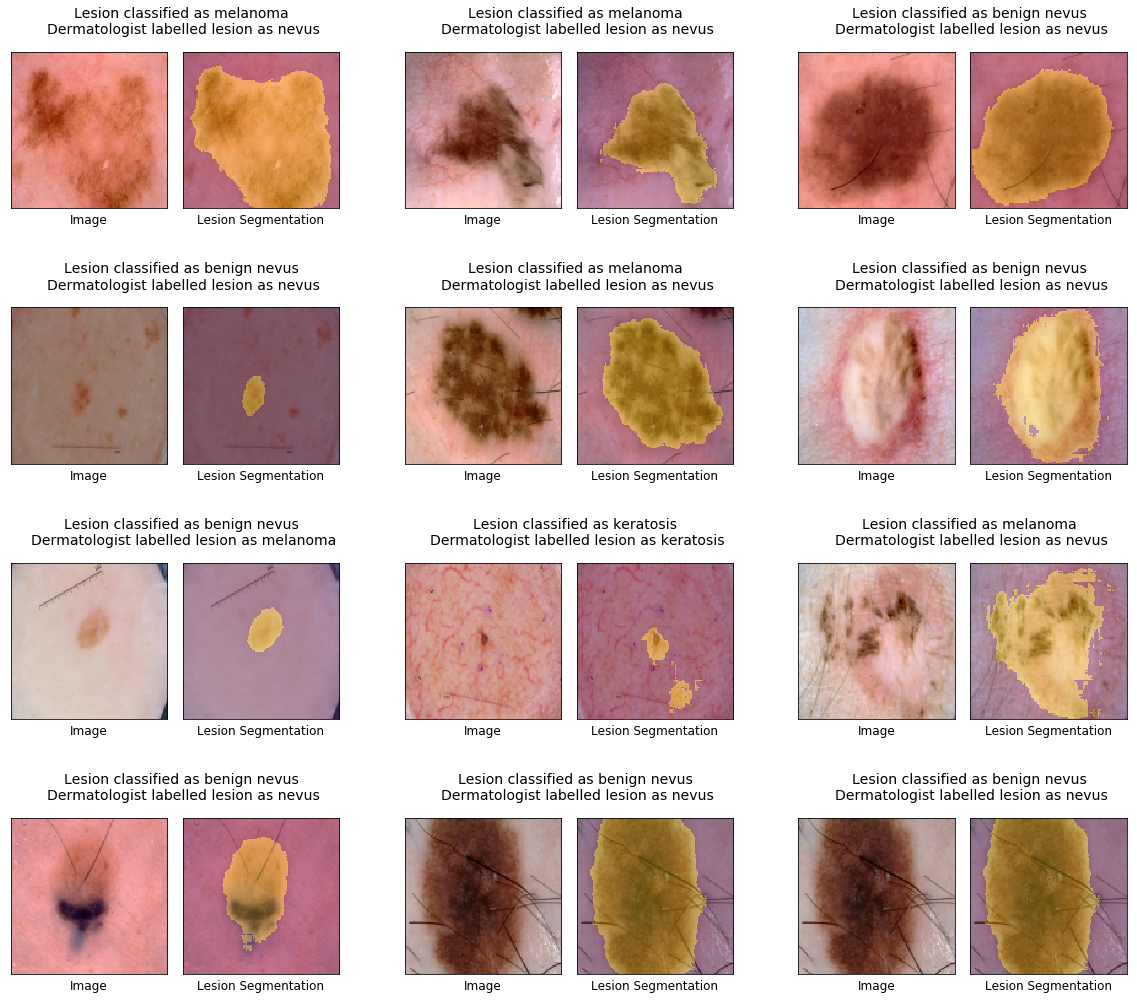

In [278]:
%%time
# get predictions of 9 ramdom images from the testset.
ran_ims = np.random.choice(img_fns, size=(12,))
cs, ss = deploy(ran_ims)
print(f'len {len(cs)}; cls - {cs}')
visualise(cs, ss, ran_ims)

len 12; cls - [2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 0]


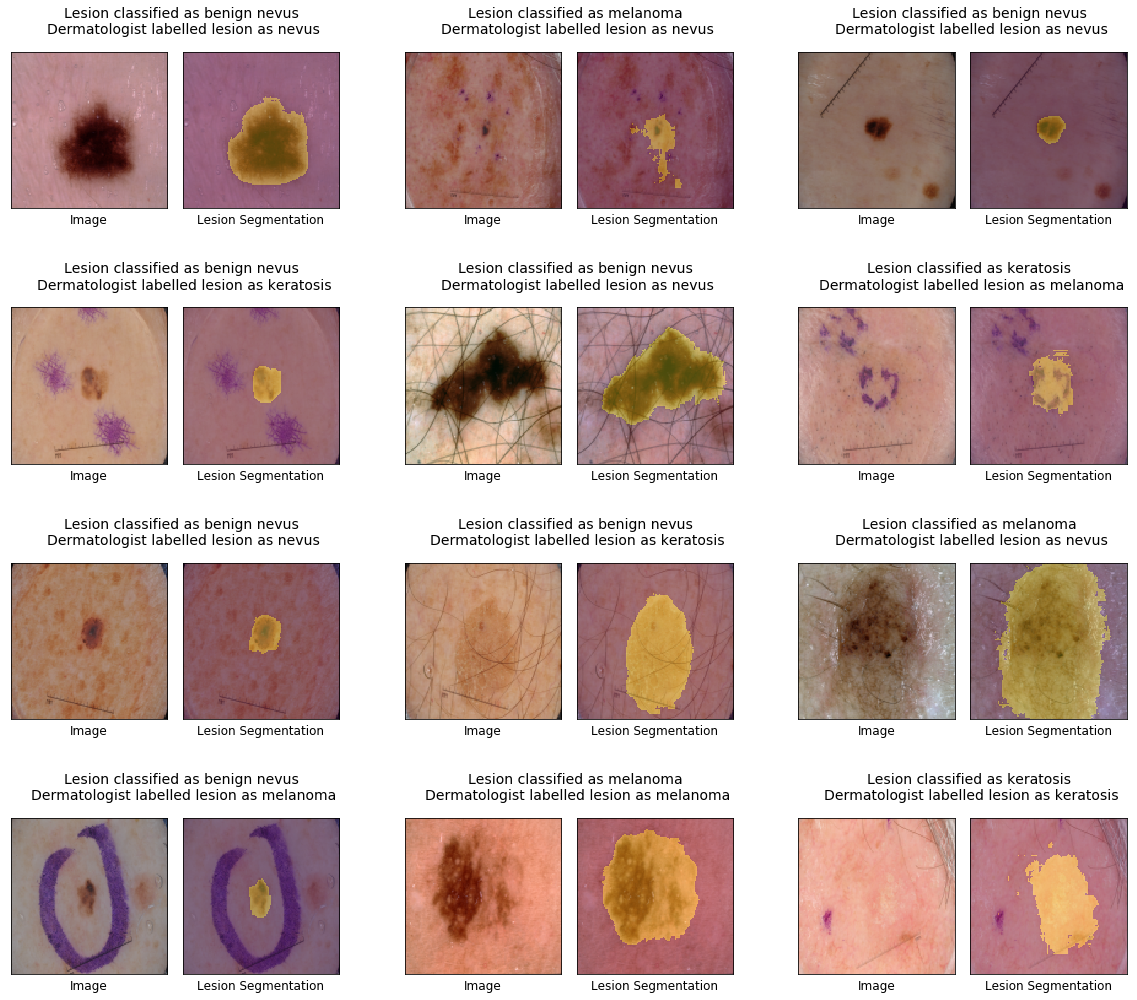

In [279]:
ran_ims = np.random.choice(img_fns, size=(12,))
cs, ss = deploy(ran_ims)
print(f'len {len(cs)}; cls - {cs}')
visualise(cs, ss, ran_ims)